In [36]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
from statsmodels.stats.diagnostic import normal_ad
sn.set(style="whitegrid")

### Cargar Datos

In [37]:
Datos = pd.read_excel('../Db.xlsx', sheet_name= 'VARIABLES DEL EXAMEN') # Cargo la base de Datos
Datos = Datos.T # Transpongo la base de datos
Datos.columns = Datos.iloc[1] # Reviso las Columnas y sus nombres
Datos = Datos[2:] 
Datos.index = pd.date_range(start='1961-12-31', periods=len(Datos), freq='Y') # Le pongo la frecuencia y la fecha inicial a los datos
Datos = Datos.astype(float)

In [38]:
Columnas(Datos,'int') # Aqui Busco en las columnas de datos las variables que necesito

Ahorro interno bruto (US$ a precios actuales)
Ajuste de los términos de intercambio (UMN a precios constantes)
Crédito interno al sector privado otorgado por los bancos (% del PIB)
Crédito interno neto (UMN a precios actuales)
Ingreso interno bruto (UMN a precios constantes)
Recursos de agua dulce  internos renovables per cápita (metros cúbicos)
Recursos de agua dulce  internos renovables, total (billones de metros cúbicos)


In [39]:
data = Datos.copy()
data = data[['Total de reservas (incluye oro, US$ a precios actuales)','Ahorro interno bruto (US$ a precios actuales)','Crédito interno al sector privado otorgado por los bancos (% del PIB)']]
data.columns = ['Reservas','SIB','Credito Bancario'] # Asi nombrare a estas tres variables con fines practicos
data.head(10)

,Reservas,SIB,Credito Bancario
1961-12-31,7404270.65,1.750842e+07,2.224959
1962-12-31,4005989.98,2.685185e+07,2.513610
1963-12-31,10404576.44,3.131313e+07,5.242329
1964-12-31,22546124.32,6.767677e+07,6.504719
1965-12-31,36572986.48,7.095960e+07,6.367688
1966-12-31,41219613.49,7.373737e+07,6.866667
1967-12-31,37943132.80,8.148148e+07,6.668894
1968-12-31,41648875.10,1.180135e+08,7.532378
1969-12-31,42066867.20,1.338384e+08,7.883919
1970-12-31,46379966.09,1.689394e+08,8.781659


### Analisis de Estacionariedad a las Variables

In [40]:
DFuller(data['Reservas'])
DFuller(data['SIB'])
DFuller(data['Credito Bancario'])
print('===========================')
print('     RESULTADO       ')
print('===========================')
print('Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos')


Estadístico ADF: 1.585597437126751
Valor p: 0.9978137170762671
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: 3.0879599055259654
Valor p: 1.0
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -0.44548971531253956
Valor p: 0.9022221076701307
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
     RESULTADO       
Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos


### Analisis de Cointegración

In [50]:

lag_order = select_order(data, maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 10, BIC -> 8, FPE -> 8, HQIC ->  10>


In [57]:
print('Al 99% de confianza')
Johansen_Test(data,1,8,2)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.7055    43.4435    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    21.1428    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    8.3604    Se rechaza r = 2, existe mas de 2 relación/nes de cointegración
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.7055    72.9466    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    29.5032    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    8.3604    Se rechaza r = 2, existe mas de 2 relación/nes de cointegración


Al 99% de nivel de confianza nos dice que todos los datos se cointegran aun que el valor de r = 2 es bastante cercano puede que se requiera no usarlo

### Modelo Inicial

Para seleccionar el orden el sistema nos dice que para aic y hqic es 10 por lo que usaremos ese 

In [58]:
model = VECM(data ,coint_rank= 2, k_ar_diff= 8)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[ 1.76204636e-01 -6.73342531e-02]
 [ 3.83895058e-01 -4.30864976e-01]
 [-2.75367921e-09  6.00491709e-09]]


In [59]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Reservas
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
L1.Reservas            -0.0996      0.185     -0.540      0.590      -0.462       0.262
L1.SIB                  0.7442      0.249      2.987      0.003       0.256       1.233
L1.Credito Bancario -1.075e+07   1.31e+07     -0.822      0.411   -3.64e+07    1.49e+07
L2.Reservas            -0.6460      0.199     -3.240      0.001      -1.037      -0.255
L2.SIB                  0.3028      0.272      1.113      0.266      -0.230       0.836
L2.Credito Bancario -2.313e+07   1.09e+07     -2.117      0.034   -4.45e+07   -1.71e+06
L3.Reservas             0.0757      0.188      0.402      0.687      -0.293       0.445
L3.SIB                  0.7064      0.286      2.467      0.014       0.145       1.268
L3.Credito Bancario -7.293e+06  

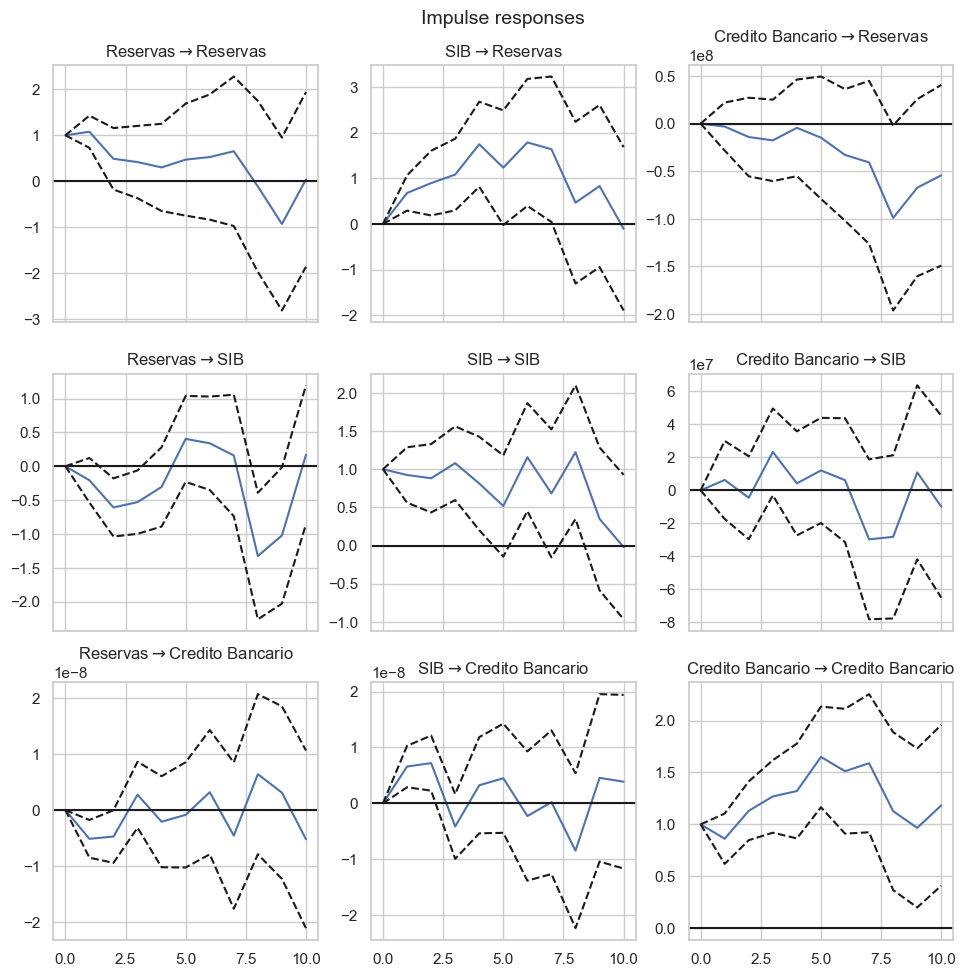

In [60]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()

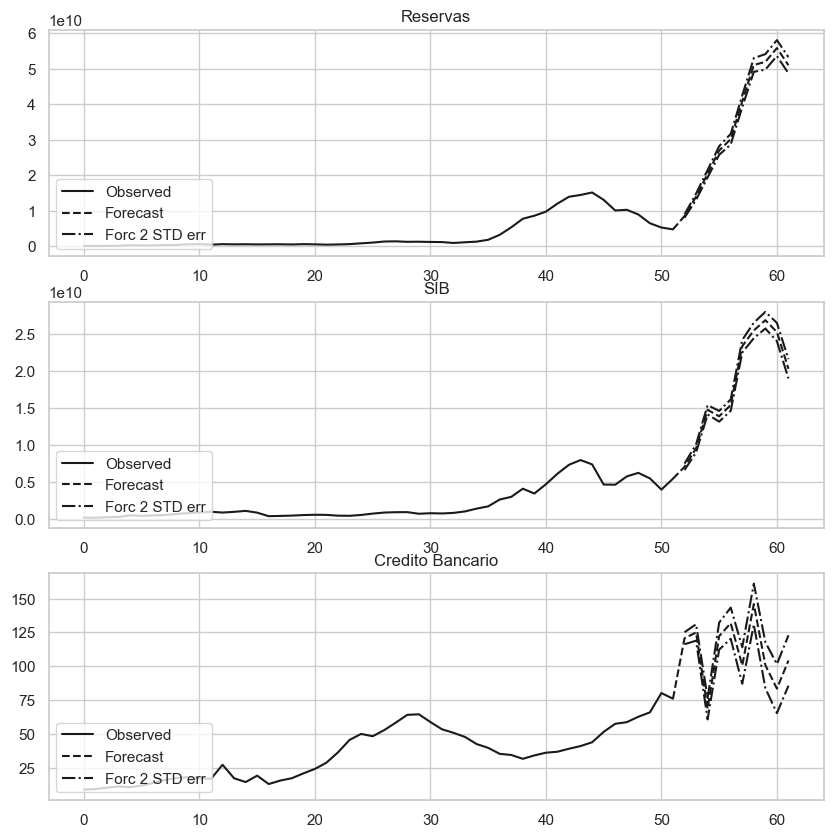

In [61]:
result.plot_forecast(steps = 10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


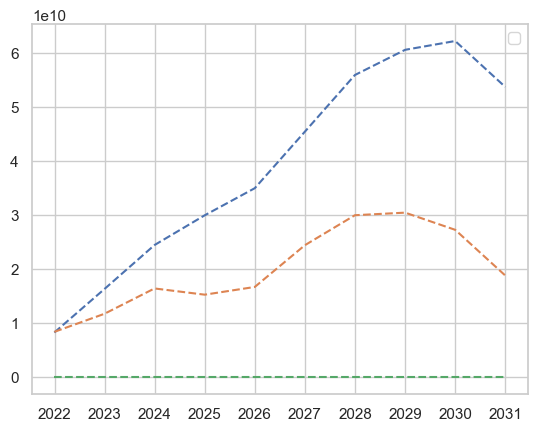

In [47]:
steps = 10
forecast, lower, upper = result.predict(steps, 0.05)
Fecha = pd.date_range(start=data.index[-1], periods=steps, freq='Y')
for i in range(len(data.columns)):
    t_pred = forecast[:,i]
    plt.plot(Fecha, t_pred, linestyle = '--')
plt.legend()
plt.show()

In [48]:

# Obtén los residuos
residuals = result.resid

# Realiza una prueba de normalidad de los residuos (por ejemplo, prueba Anderson-Darling)
ad_statistic, critical_values = normal_ad(residuals)

# Compara el estadístico con los valores críticos
for i in range(len(ad_statistic)):
    print(f'Anderson-Darling statistic: {ad_statistic[i]}, Critical value: {critical_values[i]}') # type: ignore

    # Compara el estadístico con el valor crítico
    if ad_statistic[i] > critical_values[i]: # type: ignore
        print(f'Se rechaza la hipótesis nula de normalidad para el estadístico {i + 1}.')
    else:
        print(f'No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico {i + 1}.')

Anderson-Darling statistic: 0.8028837891260494, Critical value: 0.03506788537458867
Se rechaza la hipótesis nula de normalidad para el estadístico 1.
Anderson-Darling statistic: 1.0128294061914431, Critical value: 0.010453809183295663
Se rechaza la hipótesis nula de normalidad para el estadístico 2.
Anderson-Darling statistic: 0.7973099172775093, Critical value: 0.03621385357439881
Se rechaza la hipótesis nula de normalidad para el estadístico 3.
